# <b>Assignment 3: RNNs for stock price prediction</b>


In [1]:
# install some requirement libraries
!pip install torch-summary
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 14.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=317865 sha256=1422eccd0239a723610dee5c7446f584e46cc6da13bd961e8f13622bc4d7875b
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee


In [2]:
!pip install plotly

In [3]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import yfinance as yf
import tensorflow as tf
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go
import warnings
import multiprocessing
import optuna

from tqdm.notebook import tqdm
from torchsummary import summary
from matplotlib.patches import Rectangle
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanSquaredError

In [4]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Helper function

In [5]:
def plot_mse_comparison(models_histories, model_names):
    fig, axs = plt.subplots(len(models_histories), 1, figsize=(12, len(models_histories) * 4))
    
    for i, (history, name) in enumerate(zip(models_histories, model_names)):
        axs[i].plot(history.history['mse'], label='Train MSE', color='blue', marker='o')
        axs[i].plot(history.history['val_mse'], label='Validation MSE', color='orange', marker='h')
        axs[i].set_title(f'MSE Comparison for {name}')
        axs[i].set_ylabel('MSE')
        axs[i].set_xlabel('Epoch')
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_grouped_predictions(predictions_list, indices, data_source, y_test, titles):
    num_plots = len(predictions_list)  # Number of models to plot
    fig, axs = plt.subplots(2, num_plots, figsize=(num_plots * 6, 16), sharey='row')
    # Adjust spacing between rows and columns
    plt.subplots_adjust(hspace=3.8, wspace=0.3)
    
    test_range = len(data_source) - len(y_test)
    
    for i, (predictions, idx, title) in enumerate(zip(predictions_list, indices, titles)):
        # Main plot (first row)
        ax_main = axs[0, i]
        ax_main.set_title(title, fontsize=28, pad=50)  # Add padding to the title
        ax_main.set_xlabel('Date', fontsize=18)
        if i == 0:  # Only the first column has a y-label
            ax_main.set_ylabel('Closing Price', fontsize=18)
        
        # Plot actual and predicted values
        ax_main.plot(data_source.iloc[:test_range, idx], label='Train Data', color='blue')
        ax_main.plot(data_source.iloc[test_range:, idx], label='Test Data', color='orange')
        ax_main.plot(data_source[test_range:].index, predictions[:, idx], label='Prediction', color='green')
        
        # Add a rectangle to highlight prediction area
        window_start = data_source[test_range:].index[0]
        window_end = data_source[test_range:].index[-1]
        width = window_end - window_start
        height = max(predictions[:, idx]) - min(predictions[:, idx]) + 30
        rectangle = Rectangle(
            (window_start, min(predictions[:, idx]) - 10),
            width,
            height,
            fill=False,
            edgecolor='red',
            linestyle='dashed'
        )
        ax_main.add_patch(rectangle)
        ax_main.legend(loc='lower right', fontsize=16)
        ax_main.grid(True)

        # Add some vertical spacing
        axs[1, i].set_position([axs[1, i].get_position().x0,
                               axs[1, i].get_position().y0 + 0.1,
                               axs[1, i].get_position().width,
                               axs[1, i].get_position().height])
        
        # Magnified plot (second row)
        ax_zoom = axs[1, i]
        ax_zoom.plot(data_source.iloc[test_range:, idx], color='orange', label='Test Data')
        ax_zoom.plot(data_source[test_range:].index, predictions[:, idx], color='green', label='Prediction')
        ax_zoom.set_xlim(window_start, window_end)
        ax_zoom.set_ylim(min(predictions[:, idx]) - 10, max(predictions[:, idx]) + 10)
        ax_zoom.set_title(f'{title} (Magnified)', fontsize=28, pad=50)  # Add padding to the magnified view title
        ax_zoom.set_xlabel('Date', fontsize=18)
        if i == 0:  # Only the first column has a y-label
            ax_zoom.set_ylabel('Closing Price', fontsize=18)
        ax_zoom.legend(loc='lower right', fontsize=16)
        ax_zoom.grid(True)
    plt.tight_layout()
    plt.show()

## <b>1: Exploratory Data Analysis (EDA)</b>

In [6]:
ticker = yf.Ticker('GOOG')

# Define the range of start and end dates
date_start = '2012-01-03'

# Get past data for the aforementioned date range
dataset = ticker.history(start=date_start, end=None)
dataset.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,16.222704,16.600606,16.208540,16.532528,147611217,0.0,0.0
2012-01-04 00:00:00-05:00,16.523088,16.652782,16.413519,16.603836,114989399,0.0,0.0
2012-01-05 00:00:00-05:00,16.451035,16.496751,16.304445,16.373516,131808205,0.0,0.0
2012-01-06 00:00:00-05:00,16.376995,16.398115,16.144440,16.150156,108119746,0.0,0.0
2012-01-09 00:00:00-05:00,16.062697,16.075122,15.434848,15.465409,233776981,0.0,0.0


In [7]:
# Define candle stick trace
candlestick_trace = go.Candlestick(
    x=dataset.index,
    open=dataset['Open'],
    high=dataset['High'],
    low=dataset['Low'],
    close=dataset['Close'],
    name='Candlestick'
)

# Layout
layout = go.Layout(
    title='GOOG Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

fig = go.Figure(data=[candlestick_trace], layout=layout)

fig.update_layout(xaxis_rangeslider_visible=False)

fig.show()

In [8]:
col_close = dataset.pop('Close')
dataset.insert(0, 'Close', col_close)
dataset.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,16.532528,16.222704,16.600606,16.208540,147611217,0.0,0.0
2012-01-04 00:00:00-05:00,16.603836,16.523088,16.652782,16.413519,114989399,0.0,0.0
2012-01-05 00:00:00-05:00,16.373516,16.451035,16.496751,16.304445,131808205,0.0,0.0
2012-01-06 00:00:00-05:00,16.150156,16.376995,16.398115,16.144440,108119746,0.0,0.0
2012-01-09 00:00:00-05:00,15.465409,16.062697,16.075122,15.434848,233776981,0.0,0.0


In [9]:
dataset.tail()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-11-25 00:00:00-05:00,169.429993,167.990005,170.460007,167.399994,21395700,0.0,0.0
2024-11-26 00:00:00-05:00,170.619995,169.490005,171.494995,169.429993,14937500,0.0,0.0
2024-11-27 00:00:00-05:00,170.820007,170.679993,171.139999,169.669998,12433400,0.0,0.0
2024-11-29 00:00:00-05:00,170.490005,170.059998,170.869995,168.750000,9250700,0.0,0.0
2024-12-02 00:00:00-05:00,172.979996,170.320007,173.600006,170.270004,16589400,0.0,0.0


In [10]:
dataset.shape

(3250, 7)

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3250 entries, 2012-01-03 00:00:00-05:00 to 2024-12-02 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         3250 non-null   float64
 1   Open          3250 non-null   float64
 2   High          3250 non-null   float64
 3   Low           3250 non-null   float64
 4   Volume        3250 non-null   int64  
 5   Dividends     3250 non-null   float64
 6   Stock Splits  3250 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 203.1 KB


In [12]:
dataset.isna().sum().to_frame(name='num_of_NaN')

,num_of_NaN
Close,0
Open,0
High,0
Low,0
Volume,0
Dividends,0
Stock Splits,0


In [13]:
dataset.duplicated().sum()

0

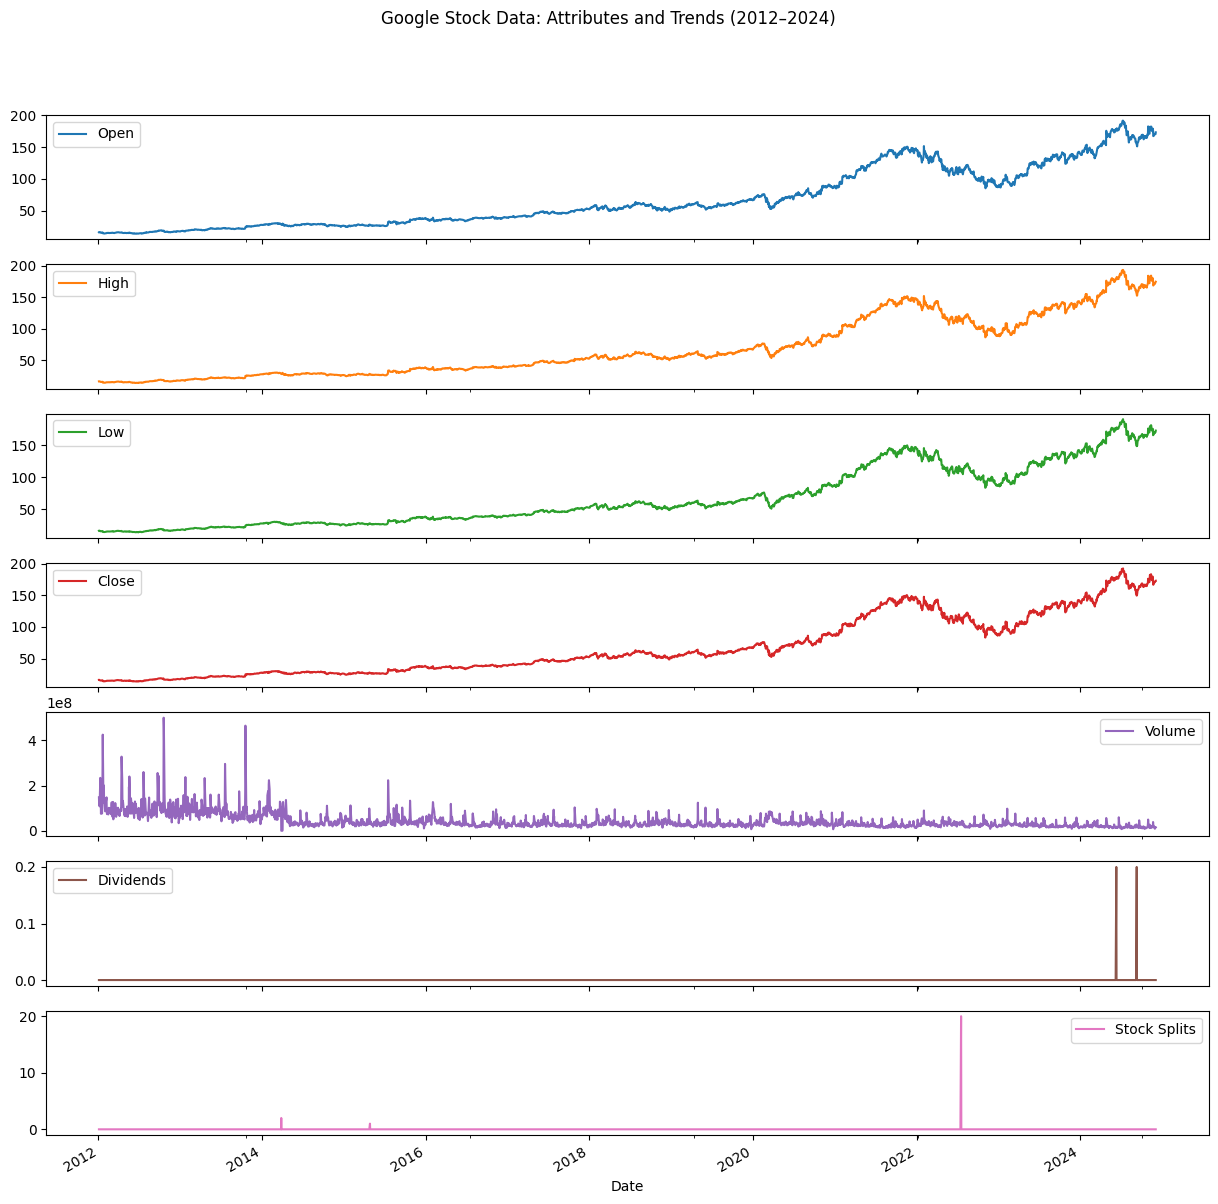

In [7]:
dataset.plot(subplots=True, figsize=(15, 15))
plt.suptitle('Google Stock Data: Attributes and Trends (2012–2024)', y=0.95)
plt.show()

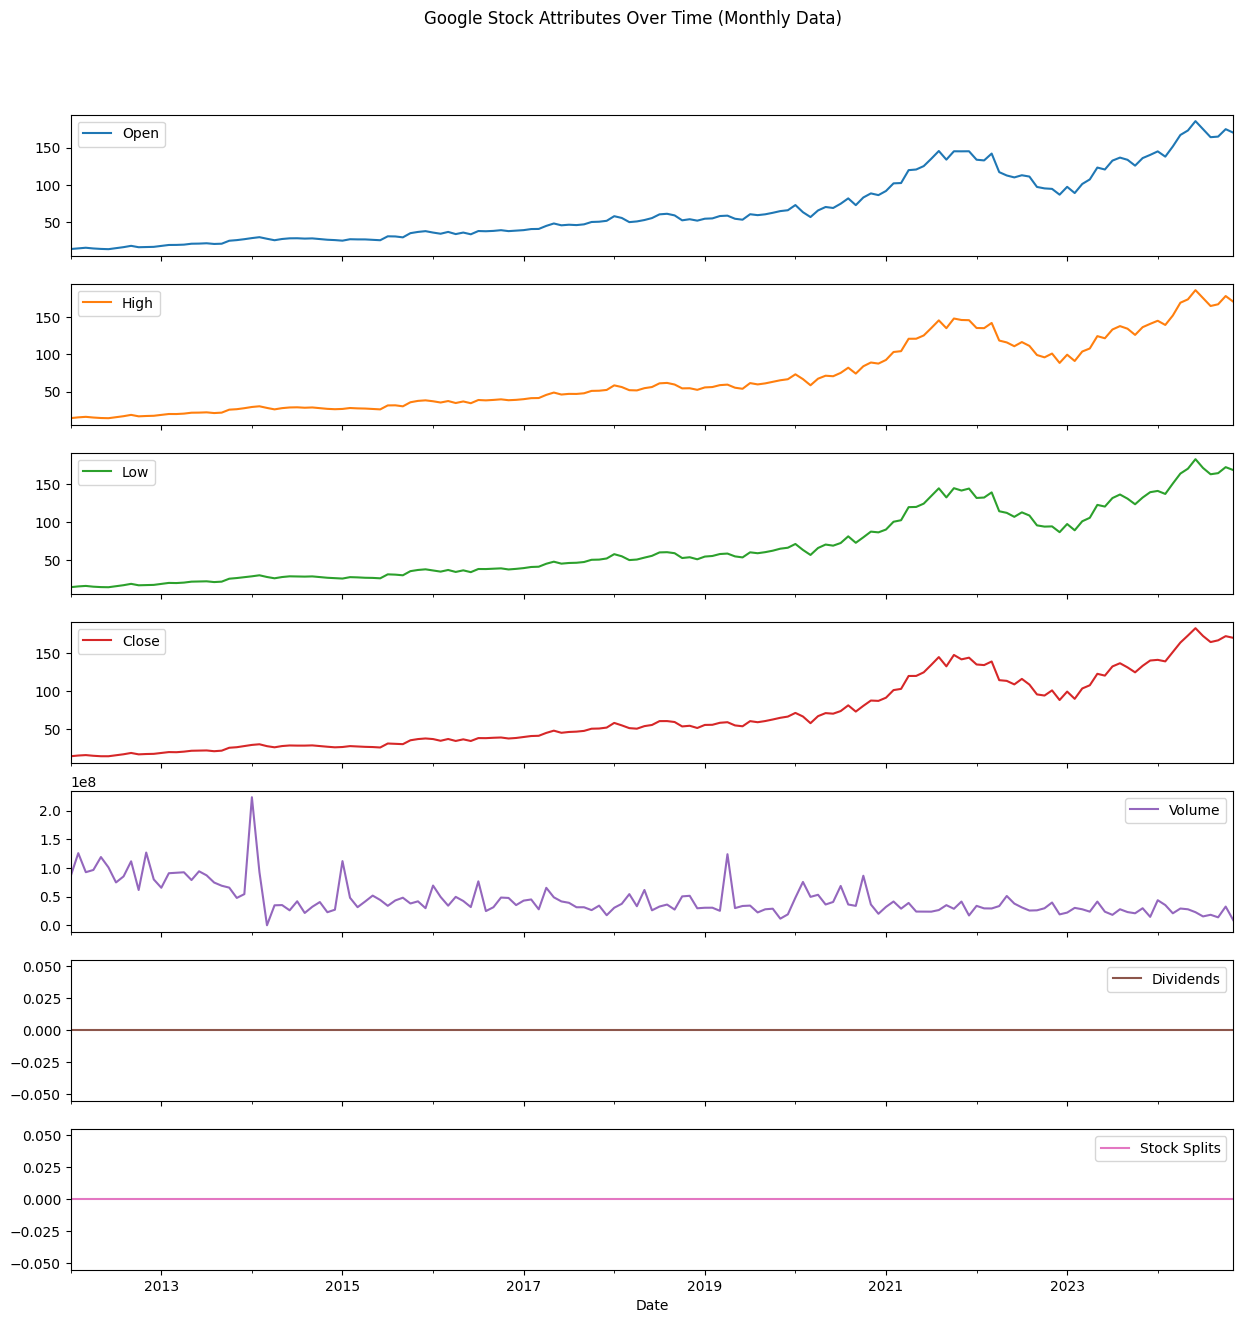

In [8]:
dataset.asfreq('M', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('Google Stock Attributes Over Time (Monthly Data)', y=0.95)
plt.show()

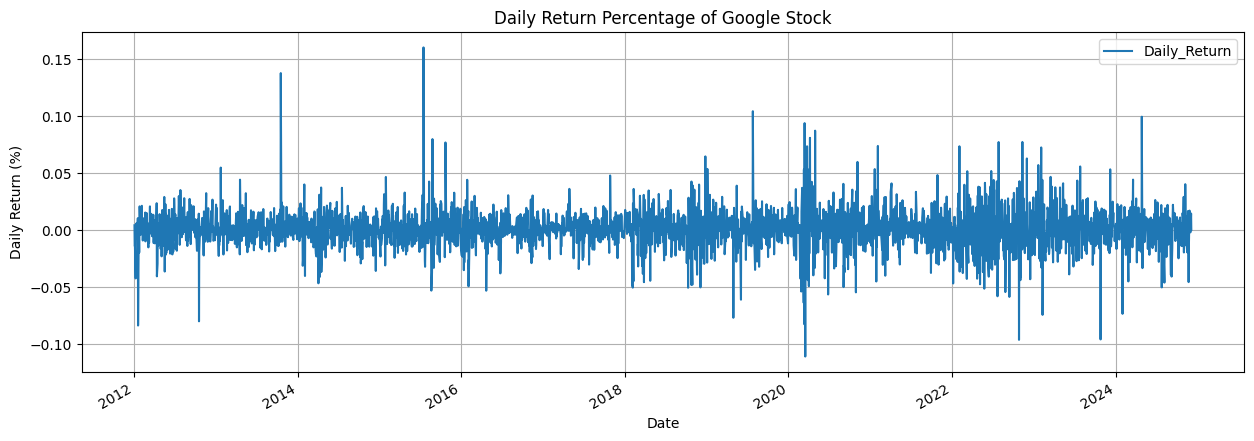

In [9]:
# Compute daily return percentage
dataset = dataset.assign(Daily_Return=lambda x: x['Close'].pct_change())

# Plot daily return
dataset['Daily_Return'].plot(figsize=(15, 5), legend=True)

# Add plot title and labels
plt.title('Daily Return Percentage of Google Stock')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.grid(True)
plt.show()

## <b>2. Data Pre-processing</b>

In [18]:
# Data Normalization
dataset_clone = dataset.copy(deep=True)
scaler = MinMaxScaler(feature_range=(0, 15))

# Apply the scaler to all relevant columns at once
columns_to_scale = ['Open', 'High', 'Low', 'Close']
dataset_clone[columns_to_scale] = scaler.fit_transform(dataset_clone[columns_to_scale])

# Extract the scaled data as a NumPy array
data = dataset_clone[columns_to_scale].values
data.shape

(3250, 4)

In [19]:
# Preparing Data for Time Series
seq_length = 11
sequences = []
for index in range(len(data) - seq_length + 1): 
    sequences.append(data[index: index + seq_length])
sequences = np.array(sequences)

In [20]:
# Define percentages for validation and test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

# Calculate the test size ratio
test_ratio = test_set_size_percentage / 100
valid_ratio = valid_set_size_percentage / (100 - test_set_size_percentage)  # Adjust for remaining data after test split

# First, split off the test set
train_valid_sequences, x_test, train_valid_targets, y_test = train_test_split(
    sequences[:, :-1, :], sequences[:, -1, :], test_size=test_ratio, random_state=42, shuffle=False
)

# Then, split the remaining data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    train_valid_sequences, train_valid_targets, test_size=valid_ratio, random_state=42, shuffle=False
)

## <b>3. Predicting models</b>

### 3.1 Vanilla RNN

In [21]:
vanilla_rnn = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(seq_length-1, 4)),
    Dense(4)
])

vanilla_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,954 (11.54 KB)

 Trainable params: 2,954 (11.54 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
vanilla_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [23]:
vanilla_rnn_hist = vanilla_rnn.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50


I0000 00:00:1733217758.095920     137 service.cc:145] XLA service 0x7b6524008670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733217758.095972     137 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733217758.095977     137 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


25/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.8146 - mse: 17.8146 

I0000 00:00:1733217759.105022     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 15.7631 - mse: 15.7631 - val_loss: 24.5397 - val_mse: 24.5397
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6127 - mse: 5.6127 - val_loss: 10.8628 - val_mse: 10.8628
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0166 - mse: 3.0166 - val_loss: 5.5386 - val_mse: 5.5386
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9243 - mse: 1.9243 - val_loss: 2.5537 - val_mse: 2.5537
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2516 - mse: 1.2516 - val_loss: 1.1165 - val_mse: 1.1165
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6951 - mse: 0.6951 - val_loss: 0.5263 - val_mse: 0.5263
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4510 - mse: 0.4510 - val_loss: 0.3243 - val_mse: 0.3243
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3430 - mse: 0.3430 - val_loss: 0.1691 - val_mse: 0.1691
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1916 - mse: 0.19

In [24]:
# Make predictions
predictions_vanilla_rnn = vanilla_rnn.predict(x_test)

# Calculate MSE
mse = mean_squared_error(y_test, predictions_vanilla_rnn)
print(f'MSE of Model Vanilla RNN: {mse:.3f}')

# Rescale predictions back to the original scale
predictions_vanilla_rnn = scaler.inverse_transform(predictions_vanilla_rnn)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MSE of Model Vanilla RNN: 1.858


### 3.2 Stacked LSTM

In [25]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length-1, 4)))
stacked_lstm.add(LSTM(units=50))
stacked_lstm.add(Dropout(0.2))
stacked_lstm.add(Dense(units=4))

stacked_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,404 (122.67 KB)

 Trainable params: 31,404 (122.67 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
stacked_lstm.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [27]:
stacked_lstm_hist = stacked_lstm.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 11.6593 - mse: 11.6593 - val_loss: 13.1616 - val_mse: 13.1616
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0422 - mse: 3.0422 - val_loss: 2.8724 - val_mse: 2.8724
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2115 - mse: 1.2115 - val_loss: 0.8730 - val_mse: 0.8730
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7047 - mse: 0.7047 - val_loss: 0.2828 - val_mse: 0.2828
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4113 - mse: 0.4113 - val_loss: 0.1969 - val_mse: 0.1969
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3152 - mse: 0.3152 - val_loss: 0.1354 - val_mse: 0.1354
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2331 - mse: 0.2331 - val_loss: 0.1194 - val_mse: 0.1194
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2114 - mse: 0.2114 - val_loss: 0.5851 - val_mse: 0.5851
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2126 - 

In [28]:
# Make predictions
prediction_stacked_lstm = stacked_lstm.predict(x_test)

# Calculate MSE
mse = mean_squared_error(y_test, prediction_stacked_lstm)
print(f'MSE of Model Stacked LSTM: {mse:.3f}')

# Rescale predictions back to the original scale
prediction_stacked_lstm = scaler.inverse_transform(prediction_stacked_lstm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MSE of Model Stacked LSTM: 1.051


### 3.3 Gated Recurrent Unit (GRU)

In [29]:
gru = Sequential([
    GRU(50, return_sequences=False, input_shape=(seq_length-1, 4)),
    Dense(4)
])

gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,604 (33.61 KB)

 Trainable params: 8,604 (33.61 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Compile model
gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [31]:
# Train model
gru_hist = gru.fit(x_train, 
                   y_train, 
                   epochs=50, 
                   batch_size=64, 
                   validation_data=(x_valid, y_valid))

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.6669 - mse: 15.6669 - val_loss: 24.8737 - val_mse: 24.8737
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1729 - mse: 5.1729 - val_loss: 11.7995 - val_mse: 11.7995
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2992 - mse: 3.2992 - val_loss: 5.3994 - val_mse: 5.3994
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7316 - mse: 1.7316 - val_loss: 2.3063 - val_mse: 2.3063
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2058 - mse: 1.2058 - val_loss: 0.8600 - val_mse: 0.8600
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6488 - mse: 0.6488 - val_loss: 0.3292 - val_mse: 0.3292
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3902 - mse: 0.3902 - val_loss: 0.1388 - val_mse: 0.1388
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2375 - mse: 0.2375 - val_loss: 0.1071 - val_mse: 0.1071
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1533 -

In [32]:
prediction_gru = gru.predict(x_test)
# Calculate MSE
mse = mean_squared_error(y_test, prediction_gru)
print(f'MSE of GRU: {mse:.3f}')

prediction_gru = scaler.inverse_transform(prediction_gru)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MSE of GRU: 2.005


In [33]:
# Save the entire model to a HDF5 file.
stacked_lstm.save('/kaggle/working/stacked_lstm_model.h5')

### 3.4 Hyperparameter tuning (Stacked LSTM)

In [34]:
# Load the model with custom_objects
final_model = load_model(
    '/kaggle/working/stacked_lstm_model.h5',
    custom_objects={'mse': MeanSquaredError()}
)

# Verify the model
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,406 (122.68 KB)

 Trainable params: 31,404 (122.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [35]:
def objective(trial, model):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 30, 100)
    
    # Clone the model to avoid modifying the original
    tuning_model = tf.keras.models.clone_model(model)
    tuning_model.set_weights(model.get_weights())
    
    # Recompile the model with tuned learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    tuning_model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    # Train the model with tuned hyperparameters
    hyper_history = tuning_model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_valid, y_valid),
        verbose=0
    )
    
    # Predict and calculate validation loss
    predictions = tuning_model.predict(x_valid)
    val_loss = mean_squared_error(y_valid, predictions)
    
    return val_loss

# Create an Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, final_model), n_trials=50)

# Print best trial details
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value (validation loss):', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Retrain the model with best hyperparameters
best_model = tf.keras.models.clone_model(final_model)
best_model.set_weights(stacked_lstm.get_weights())
best_optimizer = tf.keras.optimizers.Adam(learning_rate=trial.params['learning_rate'])
best_model.compile(optimizer=best_optimizer, loss='mse', metrics=['mse'])

# Fit with best hyperparameters
best_model.fit(
    x_train,
    y_train,
    epochs=trial.params['epochs'],
    batch_size=trial.params['batch_size'],
    validation_data=(x_valid, y_valid)
)

# Predict and calculate MSE on test set
prediction_best_lstm = best_model.predict(x_test)
prediction_best_lstm = scaler.inverse_transform(prediction_best_lstm)

# Save the best model
best_model.save('best_stacked_lstm.h5')

[I 2024-12-03 09:23:15,177] A new study created in memory with name: no-name-e75b4515-18ce-48a4-9f34-5526c28d6c46


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:23:30,869] Trial 0 finished with value: 0.05323142130131528 and parameters: {'learning_rate': 0.00025315968288060626, 'batch_size': 128, 'epochs': 99}. Best is trial 0 with value: 0.05323142130131528.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:23:42,980] Trial 1 finished with value: 0.0329687756648342 and parameters: {'learning_rate': 0.0017260457522443777, 'batch_size': 128, 'epochs': 70}. Best is trial 1 with value: 0.0329687756648342.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:23:54,789] Trial 2 finished with value: 0.039842041556341364 and parameters: {'learning_rate': 0.0002327867622761286, 'batch_size': 64, 'epochs': 41}. Best is trial 1 with value: 0.0329687756648342.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:24:08,439] Trial 3 finished with value: 0.035968798194680116 and parameters: {'learning_rate': 0.00017789687485338982, 'batch_size': 64, 'epochs': 47}. Best is trial 1 with value: 0.0329687756648342.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:24:20,128] Trial 4 finished with value: 0.1907850695558693 and parameters: {'learning_rate': 0.005727454615205534, 'batch_size': 128, 'epochs': 68}. Best is trial 1 with value: 0.0329687756648342.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 09:24:34,878] Trial 5 finished with value: 0.03495302030256353 and parameters: {'learning_rate': 0.0001326992479970807, 'batch_size': 64, 'epochs': 54}. Best is trial 1 with value: 0.0329687756648342.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:24:43,168] Trial 6 finished with value: 0.10804875761166624 and parameters: {'learning_rate': 0.002367575775188857, 'batch_size': 128, 'epochs': 45}. Best is trial 1 with value: 0.0329687756648342.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:24:58,049] Trial 7 finished with value: 0.0594273896605598 and parameters: {'learning_rate': 0.001134629811405919, 'batch_size': 128, 'epochs': 92}. Best is trial 1 with value: 0.0329687756648342.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:25:14,256] Trial 8 finished with value: 0.046925487833452434 and parameters: {'learning_rate': 0.002761395191030266, 'batch_size': 64, 'epochs': 59}. Best is trial 1 with value: 0.0329687756648342.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:25:46,141] Trial 9 finished with value: 0.0579409024892112 and parameters: {'learning_rate': 0.0032060265584108855, 'batch_size': 32, 'epochs': 79}. Best is trial 1 with value: 0.0329687756648342.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-03 09:26:17,295] Trial 10 finished with value: 0.036424929378664865 and parameters: {'learning_rate': 0.0006497904940326715, 'batch_size': 32, 'epochs': 75}. Best is trial 1 with value: 0.0329687756648342.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:26:26,695] Trial 11 finished with value: 0.03028551033270494 and parameters: {'learning_rate': 0.0008469769982980317, 'batch_size': 64, 'epochs': 30}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:26:33,312] Trial 12 finished with value: 0.03793879597818257 and parameters: {'learning_rate': 0.000805317895957565, 'batch_size': 128, 'epochs': 32}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:26:55,568] Trial 13 finished with value: 0.06644908940535244 and parameters: {'learning_rate': 0.00043887012641680574, 'batch_size': 64, 'epochs': 85}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:27:22,398] Trial 14 finished with value: 0.21688940145438695 and parameters: {'learning_rate': 0.0014407534825451641, 'batch_size': 32, 'epochs': 66}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:27:29,587] Trial 15 finished with value: 0.06504815110292443 and parameters: {'learning_rate': 0.008895561713125284, 'batch_size': 128, 'epochs': 36}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:27:44,729] Trial 16 finished with value: 0.04093880689566021 and parameters: {'learning_rate': 0.00156209152664901, 'batch_size': 64, 'epochs': 55}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:28:05,169] Trial 17 finished with value: 0.034516662402569384 and parameters: {'learning_rate': 0.0004993935140895729, 'batch_size': 64, 'epochs': 77}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:28:16,064] Trial 18 finished with value: 0.040793666952038204 and parameters: {'learning_rate': 0.004460187687868434, 'batch_size': 128, 'epochs': 63}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:28:38,140] Trial 19 finished with value: 0.04243801400173088 and parameters: {'learning_rate': 0.0003624830114492338, 'batch_size': 32, 'epochs': 50}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:28:49,754] Trial 20 finished with value: 0.03748551748891445 and parameters: {'learning_rate': 0.0019735094065873307, 'batch_size': 128, 'epochs': 68}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:29:10,093] Trial 21 finished with value: 0.031436699805908325 and parameters: {'learning_rate': 0.0005519368136749699, 'batch_size': 64, 'epochs': 76}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:29:32,423] Trial 22 finished with value: 0.03461432043526091 and parameters: {'learning_rate': 0.000805565533805338, 'batch_size': 64, 'epochs': 85}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:29:51,856] Trial 23 finished with value: 0.034606741983574385 and parameters: {'learning_rate': 0.0011692728032550038, 'batch_size': 64, 'epochs': 74}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2024-12-03 09:30:13,186] Trial 24 finished with value: 0.046258048551016666 and parameters: {'learning_rate': 0.0005778853228767185, 'batch_size': 64, 'epochs': 82}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:30:37,059] Trial 25 finished with value: 0.031609898736980446 and parameters: {'learning_rate': 0.00032013519689818074, 'batch_size': 64, 'epochs': 91}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:31:01,173] Trial 26 finished with value: 0.038160397296494356 and parameters: {'learning_rate': 0.00032359280172345747, 'batch_size': 64, 'epochs': 94}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:31:24,538] Trial 27 finished with value: 0.03522580147661049 and parameters: {'learning_rate': 0.00010642250388080327, 'batch_size': 64, 'epochs': 90}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:31:49,796] Trial 28 finished with value: 0.04173940734171247 and parameters: {'learning_rate': 0.00032051223988788637, 'batch_size': 64, 'epochs': 98}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:32:13,375] Trial 29 finished with value: 0.03578325381239615 and parameters: {'learning_rate': 0.00021131076879323289, 'batch_size': 64, 'epochs': 86}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:32:39,030] Trial 30 finished with value: 0.13928282770960032 and parameters: {'learning_rate': 0.0008156358018884316, 'batch_size': 64, 'epochs': 99}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:32:51,375] Trial 31 finished with value: 0.033100706191234584 and parameters: {'learning_rate': 0.0017035409408950653, 'batch_size': 128, 'epochs': 72}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:33:07,977] Trial 32 finished with value: 0.03254703271041211 and parameters: {'learning_rate': 0.0004487211043358767, 'batch_size': 64, 'epochs': 61}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2024-12-03 09:33:25,114] Trial 33 finished with value: 0.04518310231434817 and parameters: {'learning_rate': 0.0004760158896306822, 'batch_size': 64, 'epochs': 63}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 09:33:36,941] Trial 34 finished with value: 0.06460857888308495 and parameters: {'learning_rate': 0.00024297399440575463, 'batch_size': 64, 'epochs': 41}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:33:46,500] Trial 35 finished with value: 0.03815340160620323 and parameters: {'learning_rate': 0.0001637358407054226, 'batch_size': 64, 'epochs': 31}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:34:02,484] Trial 36 finished with value: 0.04262775802043655 and parameters: {'learning_rate': 0.0003664906796511428, 'batch_size': 64, 'epochs': 59}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:34:23,832] Trial 37 finished with value: 0.03172583928074797 and parameters: {'learning_rate': 0.0006145437083897434, 'batch_size': 64, 'epochs': 81}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2024-12-03 09:34:44,656] Trial 38 finished with value: 0.036888446175126835 and parameters: {'learning_rate': 0.000689310584978307, 'batch_size': 64, 'epochs': 80}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:35:08,075] Trial 39 finished with value: 0.03575657474494584 and parameters: {'learning_rate': 0.0010719999736810248, 'batch_size': 64, 'epochs': 90}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:35:39,272] Trial 40 finished with value: 0.039990950976452985 and parameters: {'learning_rate': 0.00029073790288886866, 'batch_size': 32, 'epochs': 71}. Best is trial 11 with value: 0.03028551033270494.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 09:36:04,583] Trial 41 finished with value: 0.029417546145887596 and parameters: {'learning_rate': 0.0004831896218183574, 'batch_size': 64, 'epochs': 95}. Best is trial 41 with value: 0.029417546145887596.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 09:36:29,815] Trial 42 finished with value: 0.0369853151159535 and parameters: {'learning_rate': 0.0005636896520237438, 'batch_size': 64, 'epochs': 96}. Best is trial 41 with value: 0.029417546145887596.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2024-12-03 09:36:52,480] Trial 43 finished with value: 0.043658991417794626 and parameters: {'learning_rate': 0.00018104413148857808, 'batch_size': 64, 'epochs': 87}. Best is trial 41 with value: 0.029417546145887596.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:37:14,054] Trial 44 finished with value: 0.03884595220752502 and parameters: {'learning_rate': 0.0009177481101053589, 'batch_size': 64, 'epochs': 82}. Best is trial 41 with value: 0.029417546145887596.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:37:37,576] Trial 45 finished with value: 0.03228356805308009 and parameters: {'learning_rate': 0.0006781517911338965, 'batch_size': 64, 'epochs': 91}. Best is trial 41 with value: 0.029417546145887596.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:38:01,624] Trial 46 finished with value: 0.03470709143357968 and parameters: {'learning_rate': 0.0012979210831476015, 'batch_size': 64, 'epochs': 94}. Best is trial 41 with value: 0.029417546145887596.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:38:36,829] Trial 47 finished with value: 0.03401447625660633 and parameters: {'learning_rate': 0.0003783773447887687, 'batch_size': 32, 'epochs': 88}. Best is trial 41 with value: 0.029417546145887596.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2024-12-03 09:38:56,970] Trial 48 finished with value: 0.03226645596302452 and parameters: {'learning_rate': 0.00027916044759289626, 'batch_size': 64, 'epochs': 77}. Best is trial 41 with value: 0.029417546145887596.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-03 09:39:18,541] Trial 49 finished with value: 0.03392336387506042 and parameters: {'learning_rate': 0.0005745827210632992, 'batch_size': 64, 'epochs': 82}. Best is trial 41 with value: 0.029417546145887596.


Number of finished trials: 50
Best trial:
  Value (validation loss): 0.029417546145887596
  Params: 
    learning_rate: 0.0004831896218183574
    batch_size: 64
    epochs: 95
Epoch 1/95
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1267 - mse: 0.1267 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 2/95
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1247 - mse: 0.1247 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 3/95
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1158 - mse: 0.1158 - val_loss: 0.0528 - val_mse: 0.0528
Epoch 4/95
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1130 - mse: 0.1130 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 5/95
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1155 - mse: 0.1155 - val_loss: 0.0418 - val_mse: 0.0418
Epoch 6/95
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1113 - mse: 0.1113 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 7/95
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1117 - mse: 0.1117 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 8/95


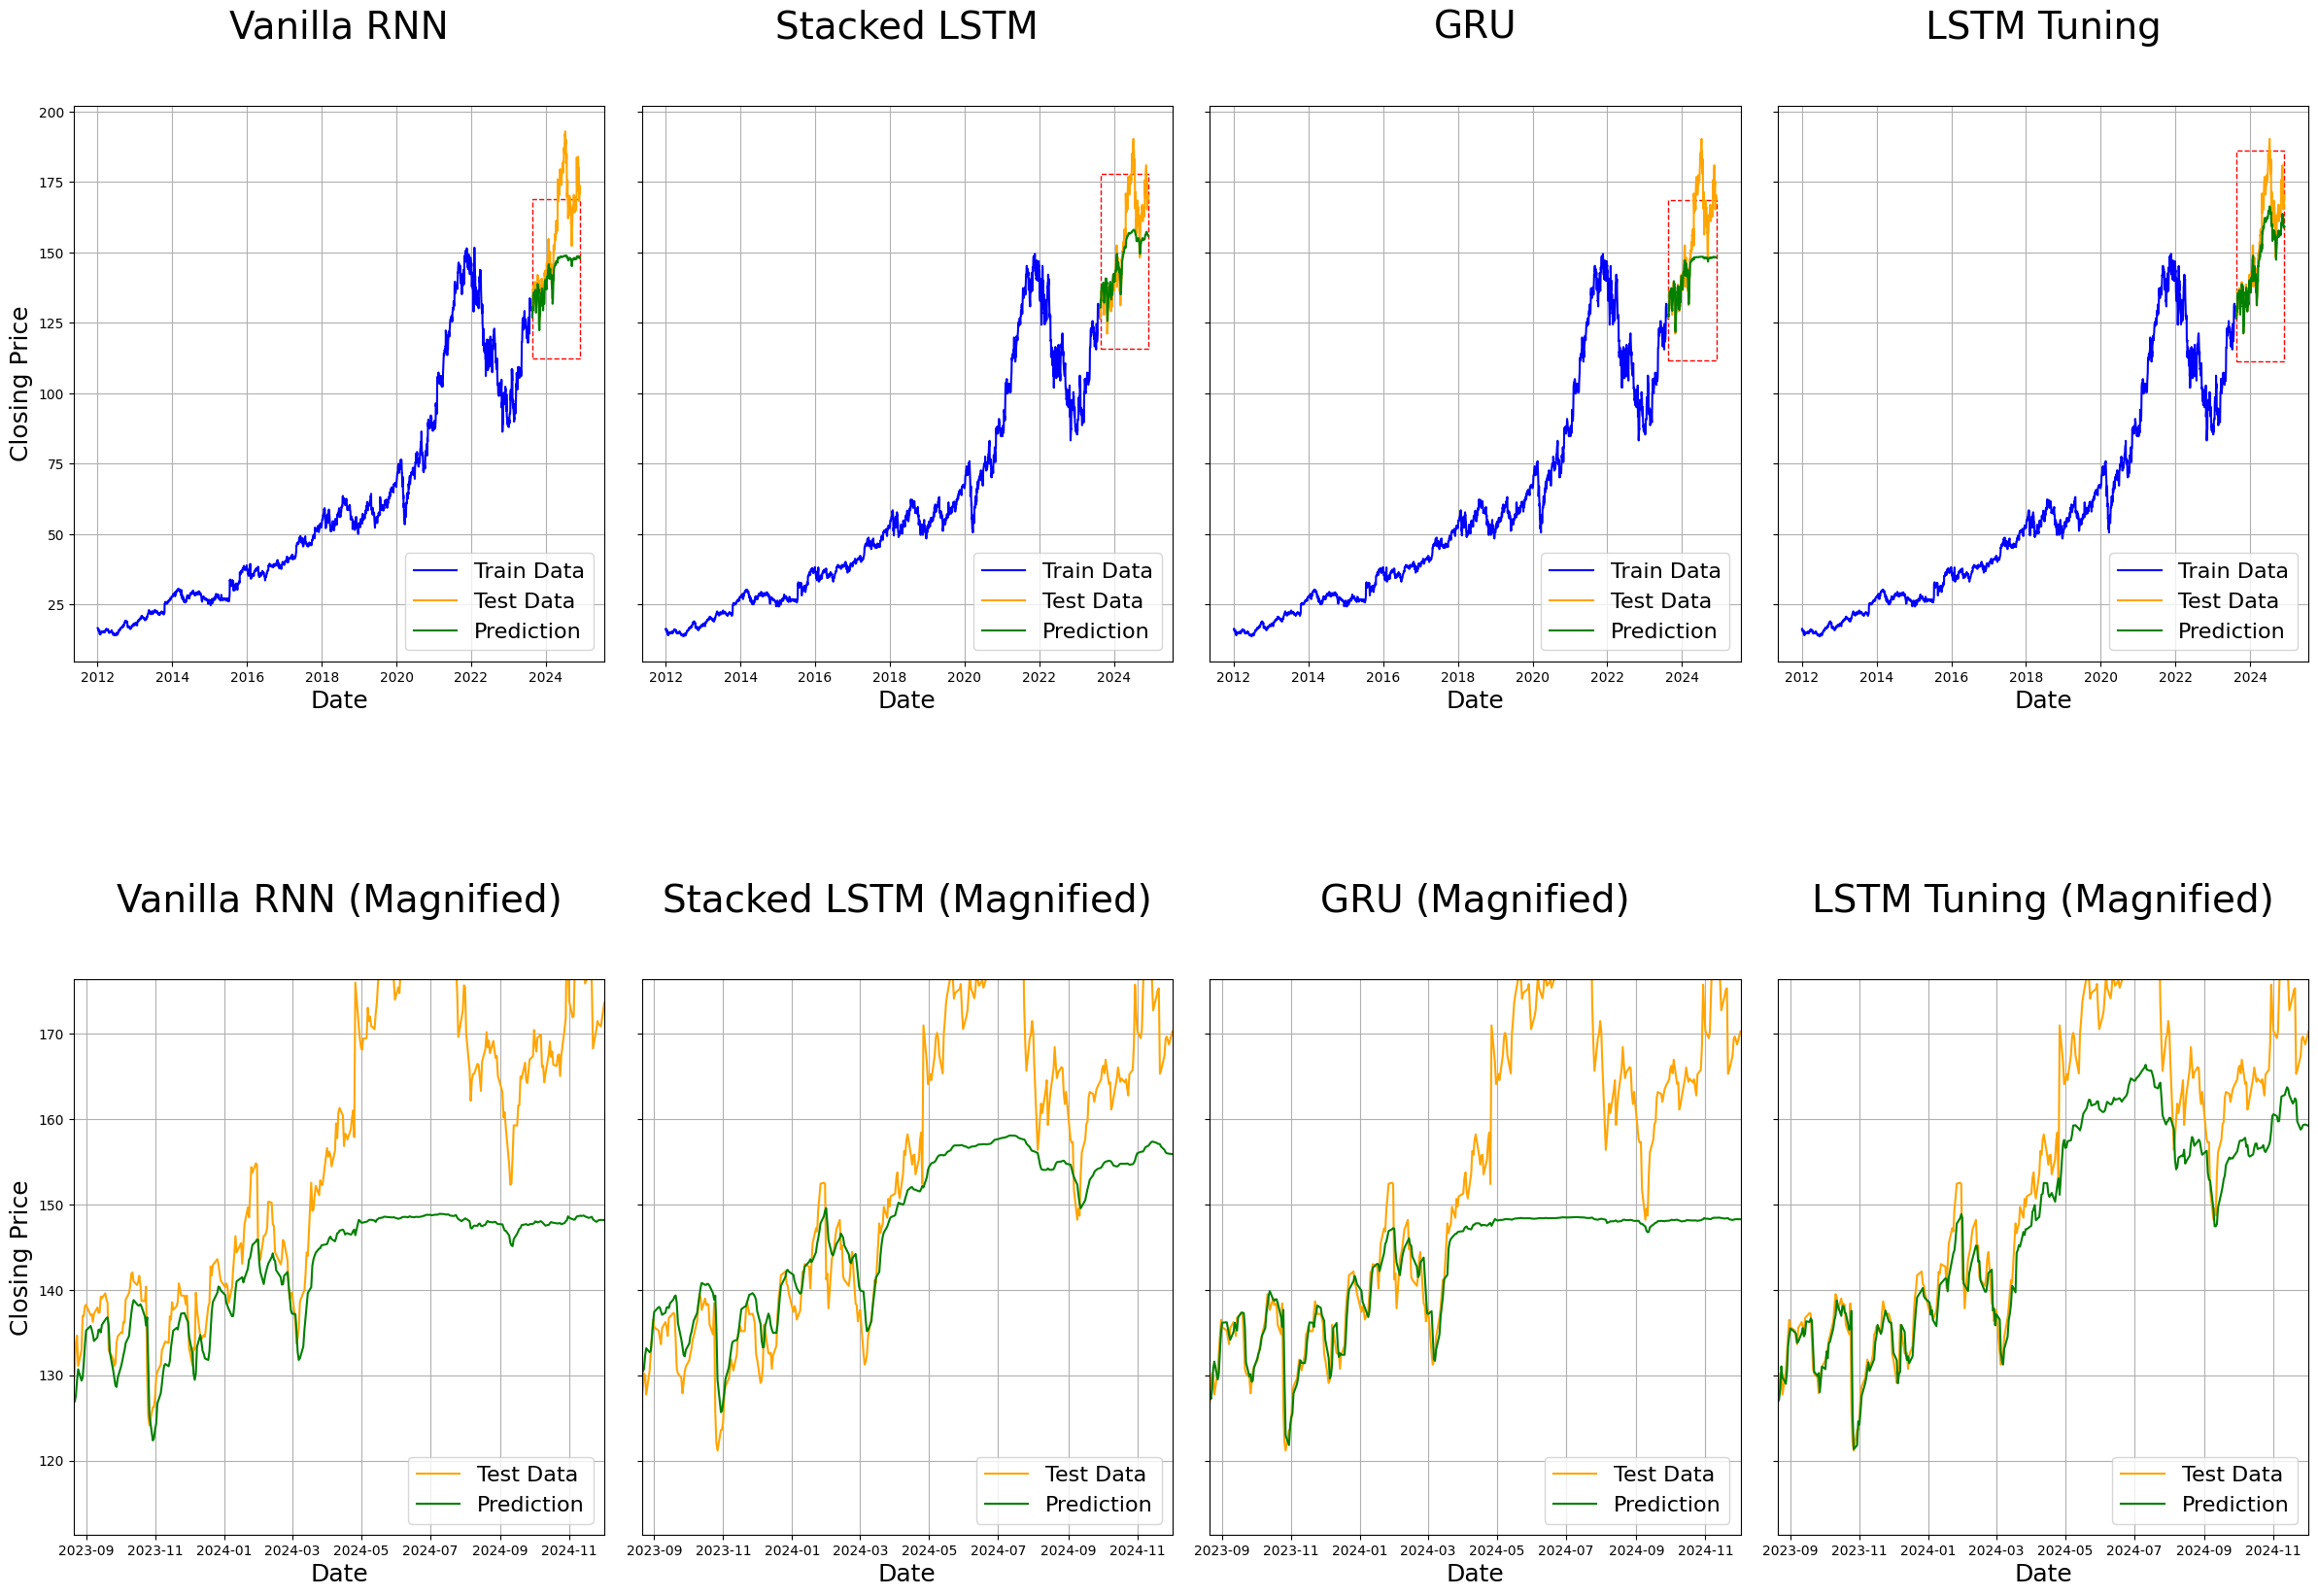

In [36]:
plot_grouped_predictions(
    predictions_list=[predictions_vanilla_rnn, prediction_stacked_lstm, prediction_gru, prediction_best_lstm],
    indices=[2, 3, 3, 3],
    data_source=dataset,
    y_test=y_test,
    titles=['Vanilla RNN', 'Stacked LSTM', 'GRU', 'LSTM Tuning']
)

### 3.5 Plotting

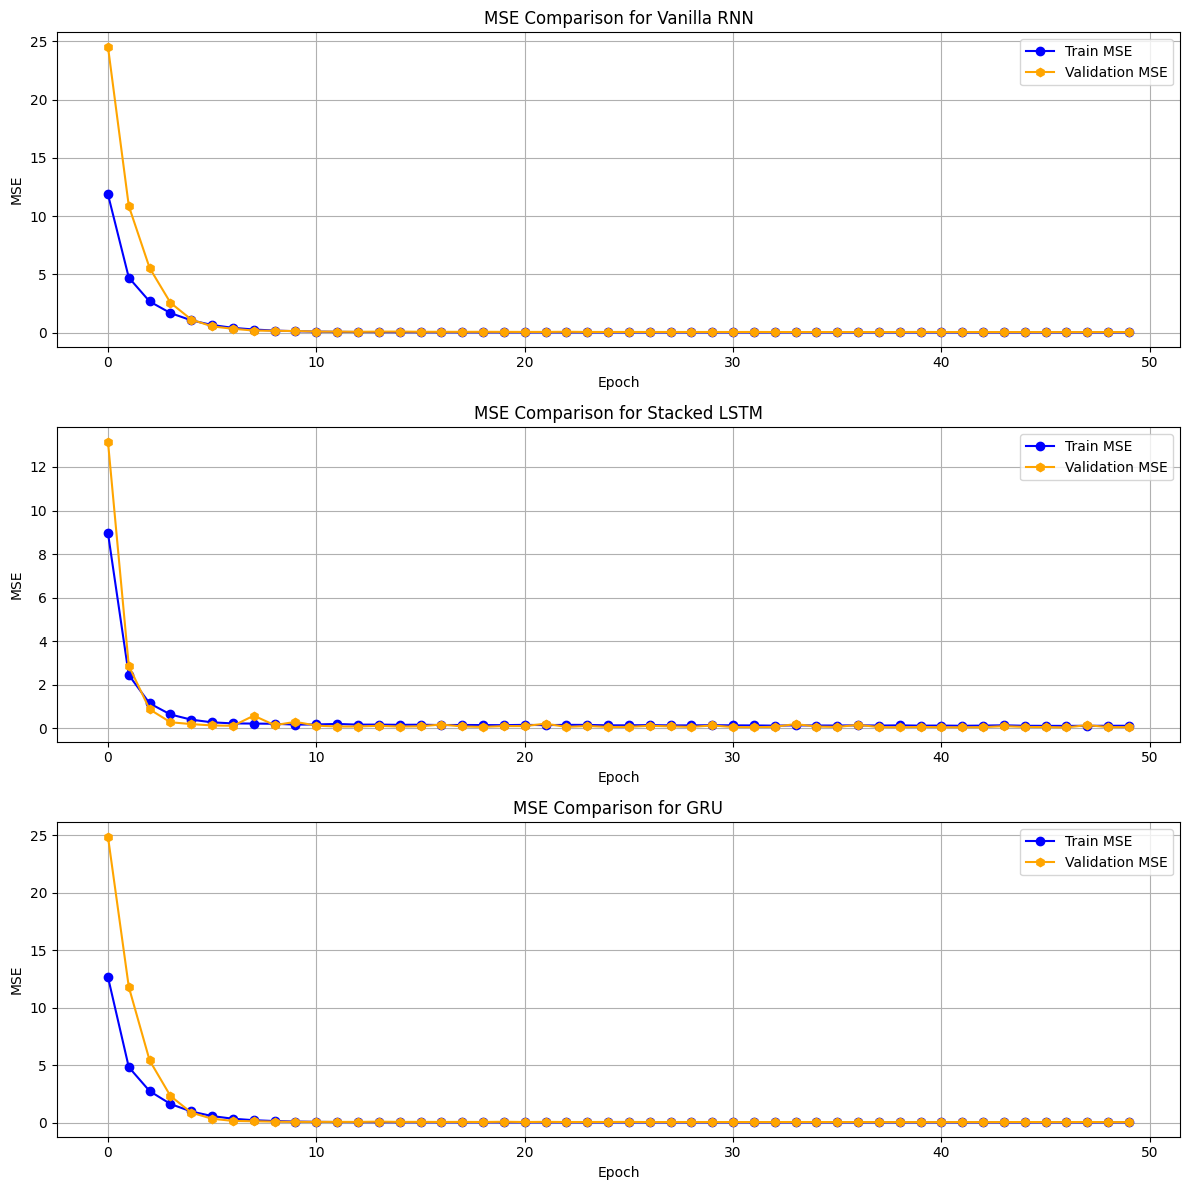

In [37]:
plot_mse_comparison(
    models_histories=[vanilla_rnn_hist, stacked_lstm_hist, gru_hist],
    model_names=['Vanilla RNN', 'Stacked LSTM', 'GRU']
)

## <b>4. Predicting the next 10 days</b>

In [38]:
prediction_best_model = best_model.predict(x_test)
# Calculate MSE
mse = mean_squared_error(y_test, prediction_best_model)
print(f'MSE of Hyperparameter-tuning Stacked LSTM: {mse:.3f}')

prediction_best_model = scaler.inverse_transform(prediction_best_model)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE of Hyperparameter-tuning Stacked LSTM: 0.623


In [39]:
# Predict the next 10 days of stock prices

# Extract the last sequence of historical data for prediction
recent_sequence = sequences[-1:, 1:, :]

# Define the number of days to predict
NUM_PREDICTIONS = 10

# Predict stock prices iteratively for the next NUM_PREDICTIONS days
for day in range(NUM_PREDICTIONS):
    # Predict the next time step
    next_prediction = best_model.predict(recent_sequence, verbose=0)
    # Append the prediction to the recent sequence
    recent_sequence = np.concatenate((recent_sequence, next_prediction[np.newaxis, :, :]), axis=1)
    # Remove the oldest time step to maintain sequence length
    recent_sequence = recent_sequence[:, 1:, :]

# Rescale the predictions back to their original values
predicted_prices = scaler.inverse_transform(recent_sequence.reshape(NUM_PREDICTIONS, 4))

# Create a DataFrame to store the predicted stock prices
predicted_df = pd.DataFrame(
    data=predicted_prices, 
    columns=['Open', 'High', 'Low', 'Close']
)

predicted_df

,Open,High,Low,Close
0,160.372440,161.663599,158.391194,159.764384
1,155.887408,157.201918,153.959588,155.416892
2,152.213685,153.528014,150.353526,151.845862
3,149.309667,150.616584,147.507054,149.011615
4,146.868210,148.166119,145.113818,146.619873
5,144.676747,145.964770,142.964328,144.466750
6,142.648380,143.925109,140.973605,142.469164
7,140.742068,142.006306,139.101623,140.588481
8,138.928966,140.179268,137.320142,138.796803
9,137.229814,138.466737,135.650153,137.116580
